In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'UCY/NLP/AirBnB_project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
ROOT_PATH = '/content/drive/My Drive/{}'.format(FOLDERNAME)
sys.path.append(ROOT_PATH)
%cd /content/drive/My\ Drive/$FOLDERNAME/

SUBMODULES = ['processing', 'utils', 'Dataset', 'model/models']

import sys
for module in SUBMODULES:
  sys.path.append('{}/{}'.format(ROOT_PATH, module))

DATASET_PATH = f'{ROOT_PATH}/Dataset'

Mounted at /content/drive
/content/drive/My Drive/UCY/NLP/AirBnB_project


In [2]:
# Installing libs
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 27.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import os
import pickle
import torch
import torch.nn as nn
import pytorch_lightning as pl

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Custom Libs
from dataloader import Dataloader
from dataset import Dataset
from listings_regressor import MLPRegressor, LossAccCallback



In [4]:
# Experiments Reproducibility
from pytorch_lightning import seed_everything

seed_everything(42, workers=True)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [5]:
# Load the precleaned and spearated datset
with open(f'{DATASET_PATH}/train_dataset.pkl', 'rb') as f:
    train_dataset = pickle.load(f)

with open(f'{DATASET_PATH}/test_dataset.pkl', 'rb') as f:
    test_dataset = pickle.load(f)

In [6]:
_, y_train = train_dataset.get()
x_not_embeddings_train = train_dataset.getListingsNotEmbeddings()
x_embeddings_train = train_dataset.getListingsEmbeddings()
print("not_embeddings_shape", x_not_embeddings_train.shape)
print("embeddings_shape", x_embeddings_train.shape)

not_embeddings_shape (5052, 146)
embeddings_shape (5052, 1536)


In [7]:
# Apply PCA to non embeddings fields + normalization
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Note that the PCA and the scaler are kept to be reused in the test
pca = PCA(n_components=60)
scaler = StandardScaler()

x_not_embeddings_train = x_not_embeddings_train.fillna(0)
x_not_embeddings_train_scaled = scaler.fit_transform(x_not_embeddings_train)
x_not_embeddings_train_60 = pca.fit_transform(x_not_embeddings_train_scaled)

In [8]:
#  define X and y for training
X_train = np.concatenate((x_not_embeddings_train_60, x_embeddings_train), axis=1)

# split data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train.values, test_size=0.2, random_state=42)

    

In [9]:
# Load and prepare Test
_, y_test = test_dataset.get()
x_not_embeddings_test = test_dataset.getListingsNotEmbeddings()
x_embeddings_test = test_dataset.getListingsEmbeddings()
print("not_embeddings_shape", x_not_embeddings_test.shape)
print("embeddings_shape", x_embeddings_test.shape)

# PCA for dimensionality reduction
pca = PCA(n_components=60)
scaler = StandardScaler()

x_not_embeddings_test = x_not_embeddings_test.fillna(0)
x_not_embeddings_test_scaled = scaler.fit_transform(x_not_embeddings_test)
x_not_embeddings_test_60 = pca.fit_transform(x_not_embeddings_test_scaled)

X_test = np.concatenate((x_not_embeddings_test_60, x_embeddings_test), axis=1)

not_embeddings_shape (1264, 146)
embeddings_shape (1264, 1536)


In [10]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
metrics_df = pd.DataFrame()
mse = []
rmse = []
r2 = []
mae = []
model_names = []

# compute the mean squared error, RMSE and R2 score and MAE and show the results on a dataframe, append the results of each model
# in a list and then create a dataframe with the results
# compute the mean squared error, RMSE and R2 score and MAE and show the results on a dataframe, append the results of each model
# in a list and then create a dataframe with the results
def compute_metrics(model, X_test, y_test):

    if model.__class__.__name__ == 'MLPRegressor':
        y_pred = model(torch.tensor(X_test).float()).detach().numpy()
        y_pred = y_pred.reshape(-1)
        
    else:
        y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    model_name = model.__class__.__name__

    # create a temporary dataframe with the results for this model
    temp_df = pd.DataFrame({
        'model': [model_name],
        'mse': [mse],
        'rmse': [rmse],
        'r2': [r2],
        'mae': [mae]
    })

    # append the temporary dataframe to the metrics_df dataframe
    global metrics_df
    metrics_df = pd.concat([metrics_df, temp_df], ignore_index=True)
    
    print(metrics_df)


In [11]:
# convert data to float32
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)
y_test = y_test.astype(np.float32)


# Define the PyTorch DataLoader for training and testing data
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
val_loader = DataLoader(val_dataset, batch_size=32)

test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test.values))
test_loader = DataLoader(val_dataset, batch_size=32)

# Define the MLPRegressor model
model = MLPRegressor()

# Define the PyTorch Lightning Trainer
trainer = pl.Trainer(callbacks=[LossAccCallback()],
                    max_epochs=50, accelerator="auto", devices="auto", strategy="auto")
# trainer = pl.Trainer(accelerator="auto", devices="auto", strategy="auto", max_epochs=10)

# Train the model
trainer.fit(model, train_loader, val_loader)

trainer.test(model, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type          | Params
----------------------------------------
0 | model | _MLPRegressor | 1.6 M 
----------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.315     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/content/drive/My Drive/UCY/NLP/AirBnB_project/model/models/listings_regressor.py:85: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  val_loss = nn.functional.mse_loss(y_hat, y)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/content/drive/My Drive/UCY/NLP/AirBnB_project/model/models/listings_regressor.py:85: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([19, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  val_loss = nn.functional.mse_loss(y_hat, y)


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.30678650736808777    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.30678650736808777}]

In [12]:
compute_metrics(model, X_test, y_test)

          model       mse      rmse        r2      mae
0  MLPRegressor  0.319651  0.565376 -2.985332  0.41961


In [13]:
# show loss curve with tensorboard to perfrom model selection
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

<IPython.core.display.Javascript object>

In [15]:
# create a dataframe with the y and y_hat next to each other
x_range = range(len(y_test))
y_hat = model(torch.tensor(X_test).float()).detach().numpy()
y_hat = y_hat.reshape(-1)
y_test = y_test
df = pd.DataFrame({'y': y_test, 'y_hat': y_hat})
df.sort_values(by=['y']).head(10)

,y,y_hat
2593,0.00,5.164347
4487,1.67,4.465868
5740,2.00,4.503202
6677,3.00,5.022975
6649,3.00,3.880777
4786,3.40,5.134653
5692,3.50,3.702809
1005,3.91,4.002384
6015,4.00,4.297400
6676,4.00,4.871713


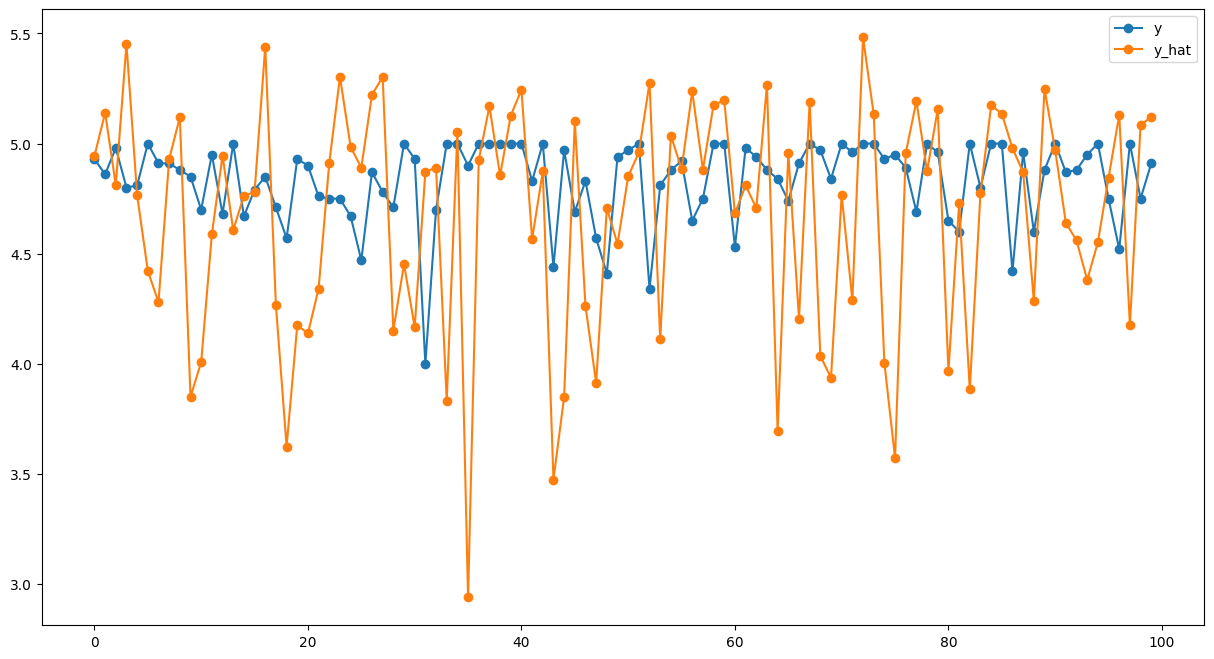

In [18]:
# plot the y and y_hat on two different graphs, plot  the first 100 values, plot in dots and lines
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.plot(x_range[:100], df.y[:100], 'o-', label='y')
plt.plot(x_range[:100], df.y_hat[:100], 'o-', label='y_hat')
plt.legend()
plt.show()

In [19]:
# We can see that the model have a good performance, comparing the y and y_hat values,in the dataframe
# and the loss curve with tensorboard. 
# Also observing the plot, we can see that the model is able to predict the values with a good accuracy.

### Random forest regressor


In [20]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# create the model
rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)

# train the model
rf.fit(X_train, y_train)

# predict
y_hat = rf.predict(X_test)

# compute the mean squared error
print(mean_squared_error(y_test, y_hat))



0.08210749153494232


In [21]:
compute_metrics(rf, X_test, y_test)

                   model       mse      rmse        r2       mae
0           MLPRegressor  0.319651  0.565376 -2.985332  0.419610
1  RandomForestRegressor  0.082107  0.286544 -0.023698  0.169283


In [22]:
# create a dataframe with the y and y_hat next to each other
y_test = y_test
df = pd.DataFrame({'y': y_test, 'y_hat': y_hat})
df.sort_values(by=['y']).head(10)

,y,y_hat
2593,0.00,4.839946
4487,1.67,4.692600
5740,2.00,4.494153
6677,3.00,4.863336
6649,3.00,4.864101
4786,3.40,4.831353
5692,3.50,4.718529
1005,3.91,4.694504
6015,4.00,4.866571
6676,4.00,4.860542


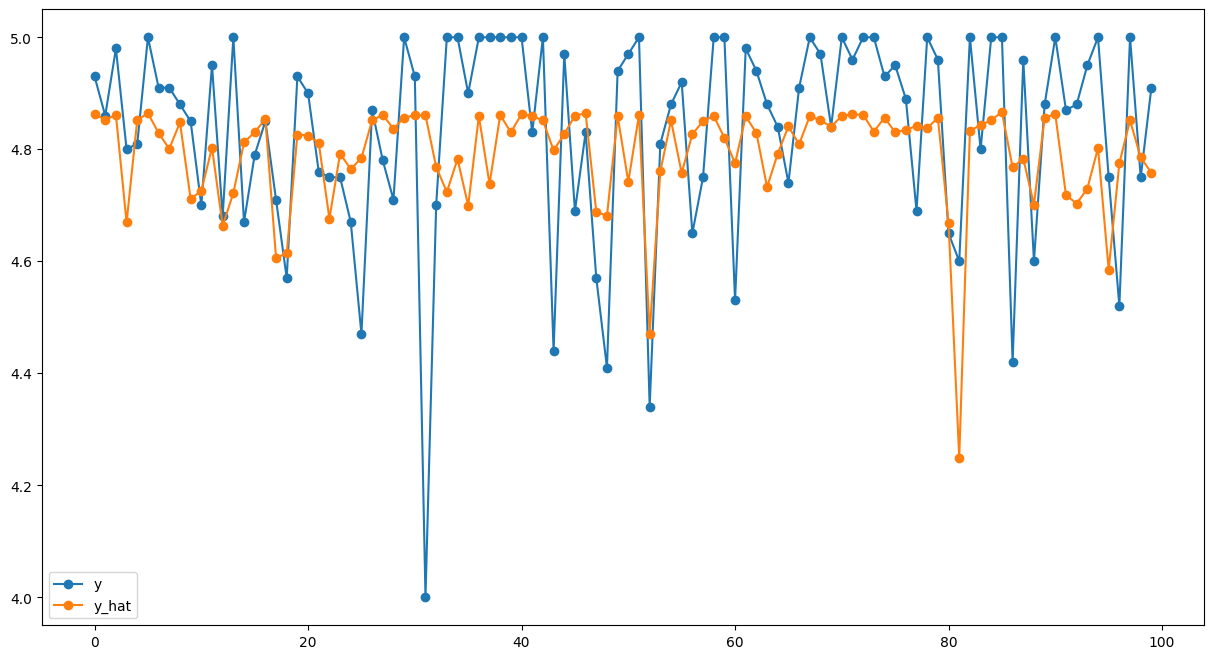

In [23]:
# plot accuracy
plt.figure(figsize=(15, 8))
plt.plot(x_range[:100], y_test[:100], 'o-', label='y')
plt.plot(x_range[:100], y_hat[:100], 'o-', label='y_hat')
plt.legend()
plt.show()

### let's try a different model, a gradient boosting regressor


In [24]:

from sklearn.ensemble import GradientBoostingRegressor

# create the model
gb = GradientBoostingRegressor(n_estimators=20, max_depth=10, random_state=42)

# train the model
gb.fit(X_train, y_train)

# predict
y_hat = gb.predict(X_test)

#  compute metrics
compute_metrics(gb, X_test, y_test)

                       model       mse      rmse        r2       mae
0               MLPRegressor  0.319651  0.565376 -2.985332  0.419610
1      RandomForestRegressor  0.082107  0.286544 -0.023698  0.169283
2  GradientBoostingRegressor  0.080134  0.283079  0.000912  0.165066


In [25]:
# create a dataframe with the y and y_hat next to each other
y_hat = y_hat
y_test = y_test
df = pd.DataFrame({'y': y_test, 'y_hat': y_hat})
df.sort_values(by=['y']).head(10)

,y,y_hat
2593,0.00,4.871837
4487,1.67,4.805113
5740,2.00,4.441468
6677,3.00,4.864255
6649,3.00,4.799231
4786,3.40,4.832985
5692,3.50,4.856041
1005,3.91,4.579287
6015,4.00,4.898669
6676,4.00,4.885951


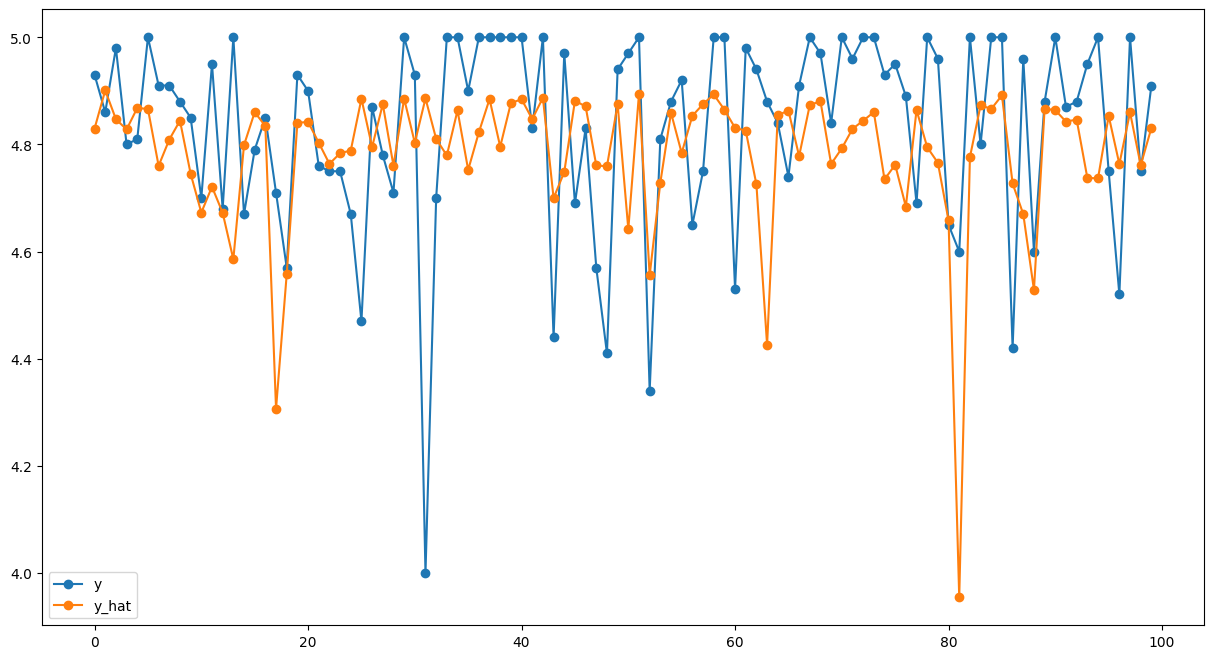

In [26]:
# plot accuracy
plt.figure(figsize=(15, 8))
plt.plot(x_range[:100], y_test[:100], 'o-', label='y')
plt.plot(x_range[:100], y_hat[:100], 'o-', label='y_hat')
plt.legend()
plt.show()

### LGBMRegressor

In [27]:
from lightgbm import LGBMRegressor


# create the model
lgbm = LGBMRegressor(n_estimators=100, max_depth=10, random_state=42)

# train the model
lgbm.fit(X_train, y_train)

# predict
y_hat = lgbm.predict(X_test)

# compute the loss metrics
compute_metrics(lgbm, X_test, y_test)

                       model       mse      rmse        r2       mae
0               MLPRegressor  0.319651  0.565376 -2.985332  0.419610
1      RandomForestRegressor  0.082107  0.286544 -0.023698  0.169283
2  GradientBoostingRegressor  0.080134  0.283079  0.000912  0.165066
3              LGBMRegressor  0.081024  0.284647 -0.010187  0.176499


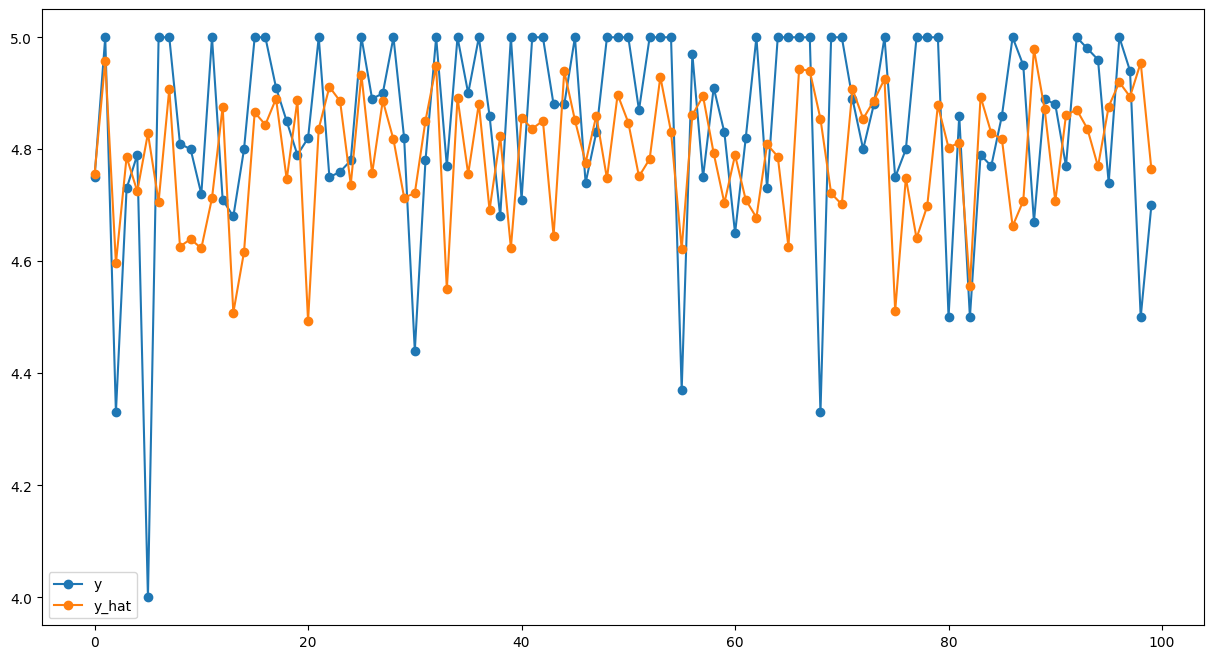

In [28]:
# plot the y and y_hat on two different graphs, plot  the first 100 values, plot in dots and lines
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.plot(x_range[:100], y_test[100:200], 'o-', label='y')
plt.plot(x_range[:100], y_hat[100:200], 'o-', label='y_hat')
plt.legend()


In [29]:
# create a dataframe with the y and y_hat next to each other
y_hat = y_hat
y_test = y_test
df = pd.DataFrame({'y': y_test, 'y_hat': y_hat})
df.sort_values(by=['y']).head(10)

,y,y_hat
2593,0.00,4.901288
4487,1.67,4.034009
5740,2.00,4.807894
6677,3.00,4.836733
6649,3.00,4.697960
4786,3.40,4.776368
5692,3.50,4.653282
1005,3.91,4.558804
6015,4.00,4.828459
6676,4.00,4.783283


In [31]:
# we need to calculate a metric to evaluate the difference of the value based on the variance of the value!!
#a such we should compare the variance errors if the error is 0.2 percent but the variance is 0.2 this mean we have an high error
y_test.std(axis=0)

0.28332004